In [1]:
import jax
import jax.numpy as jnp
import sys
sys.path.append('..')
from networks import *
from utils import *

In [2]:
import matplotlib.pyplot as plt
import scienceplots
import cmasher as cmr
plt.style.use('science')
cmap_pred = cmr.get_sub_cmap('cmr.swamp', 0.1, 1)
cmap_error = cmr.get_sub_cmap('cmr.freeze', 0.1, 1)

In [3]:
problem = "advection"
running_on = "local"
if running_on == "local":
    data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
    checkpoint_path = "C:/Users/eirik/orbax/checkpoints/"
else:
    data_path = "/cluster/work/eirikaf/data/"
    checkpoint_path = "/cluster/work/eirikaf/checkpoints/"

In [4]:
data = jnp.load(data_path + problem + ".npz")
train_val_test = train_val_test_split(data["data"], 0.8, 0.1, 0.1)
u_test = train_val_test["test"]
scaled_data = jnp.load(data_path + problem + "_z_score.npz")

In [5]:
t_test = data["t"]
x_test = data["x"]

In [6]:
a_train_s = scaled_data["a_train_s"]
u_train_s = scaled_data["u_train_s"]
a_val_s = scaled_data["a_val_s"]
u_val_s = scaled_data["u_val_s"]
a_test_s = scaled_data["a_test_s"]
u_test_s = scaled_data["u_test_s"]

x_train_s = scaled_data["x_train_s"]
t_train_s = scaled_data["t_train_s"]

x_test_s = scaled_data["x_test_s"] 
t_test_s = scaled_data["t_test_s"]

In [7]:
networks = {
    "deeponet": DeepONet,
    "modified_deeponet": ModifiedDeepONet,
    "fno_timestepping": FNOTimeStepping,
    "fno1d": FNO1d,
    "fno2d": FNO2d
}
models = {}
trainers = {}

for network_name, network in networks.items():
    print(network_name)
    try:
        trainers[network_name] = Trainer.from_checkpoint(checkpoint_path + f"{network_name}_{problem}", 
                                                    network)
        models[network_name] = trainers[network_name].model
    except:
        trainers[network_name] = Trainer.from_checkpoint2(checkpoint_path + f"{network_name}_{problem}", 
                                                    network)
        models[network_name] = trainers[network_name].model

deeponet
modified_deeponet
fno_timestepping
fno1d
fno2d


### Plot one prediction from the test set for t = 0, t $\approx$ 1, t $\approx$ 2, t $\approx$ 3

In [8]:
sample_idx = 88

u_preds = {}
for network_name, model in models.items():
    """
    To extrapolate, we use the solution at t~2 as the initial condition for the next time interval [~2, 4).
    """
    t = t_test_s[t_test < 2] # time interval [0, 2)
    # prediction on [0, 2)
    u_pred1_s = model.predict_whole_grid(a_test_s[sample_idx], x_test_s, t)
    # prediction on [~2, 4) by using the last prediction (at t~2) as initial condition
    u_pred2_s = model.predict_whole_grid(u_pred1_s[-1], x_test_s, t)
    
    # concatenate the predictions on [0, 2) and [~2, 4), making sure not to include the overlapping time point twice
    u_preds[network_name] = model.decode_u(jnp.concatenate((u_pred1_s, u_pred2_s[1:]), axis=0))[:len(t_test)]

In [9]:
# Mapping of original method names to prettier versions
pretty_names = {
    "deeponet": "DeepONet",
    "modified_deeponet": "ModifiedDeepONet",
    "fno_timestepping": "FNOTimeStepping",
    "fno1d": "FNO1d",
    "fno2d": "FNO2d"
}

In [10]:
sample_idx = 88
u_gt = u_test[sample_idx]

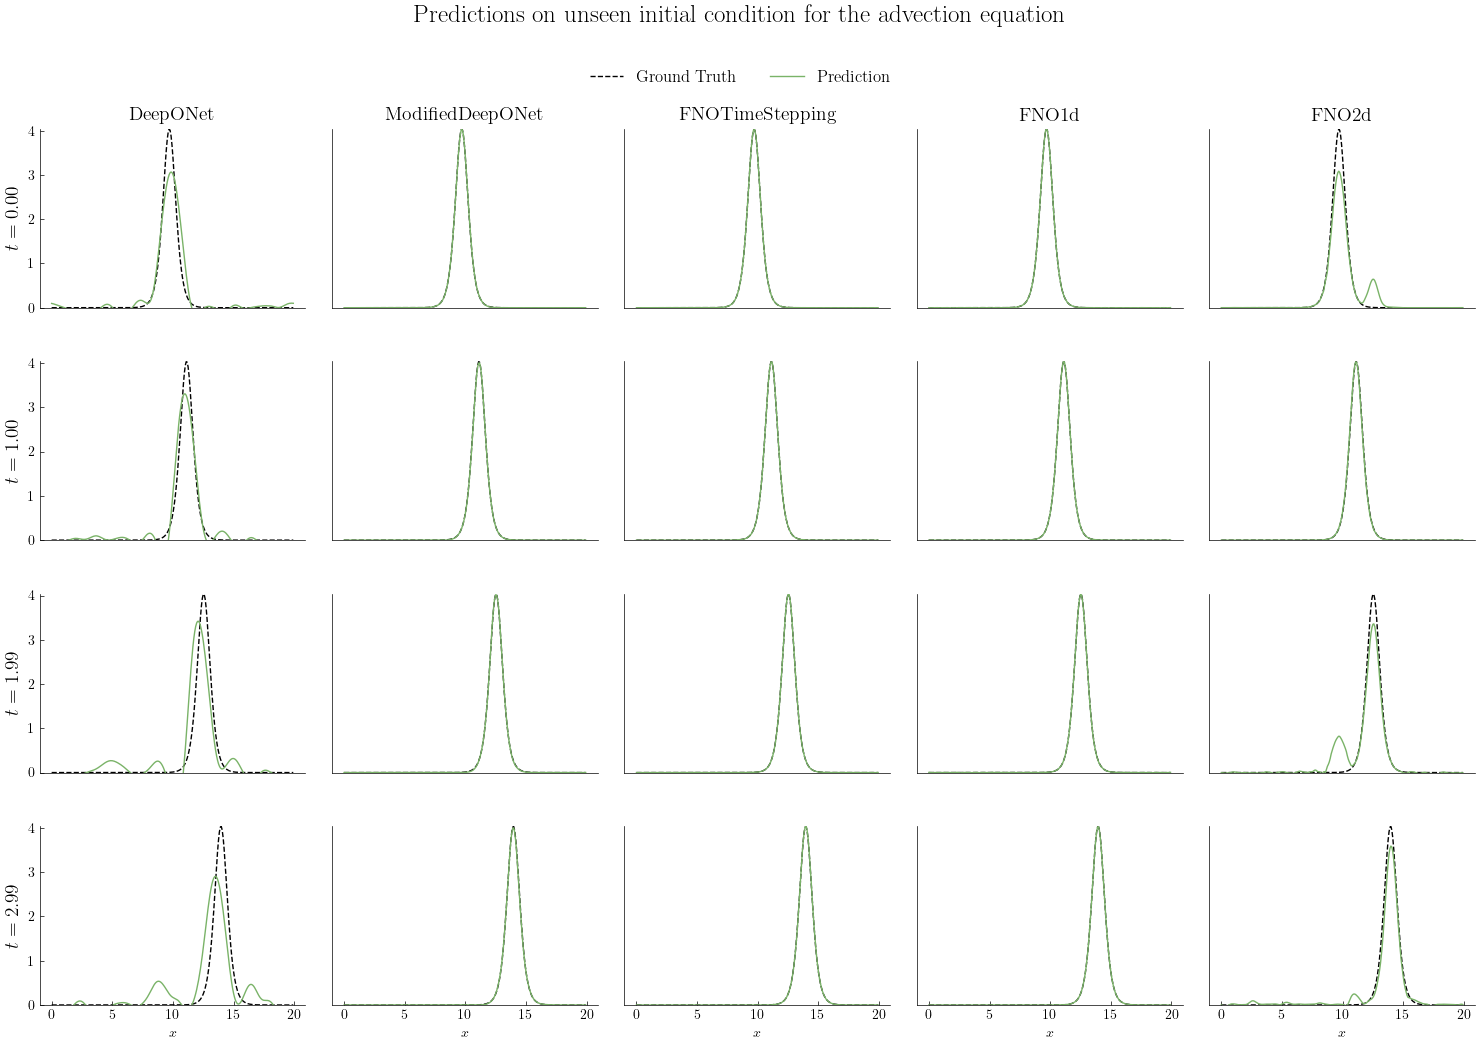

In [11]:
pred_color = "#7ab368"

time_indices = [0, jnp.where(t_test == 1)[0][0], jnp.where(t_test < 2)[0][-1], -1]
time_labels = [rf'$t={t_test[time_indices[0]]:.2f}$', rf'$t={t_test[time_indices[1]]:.2f}$', rf'$t={t_test[time_indices[2]]:.2f}$', rf'$t={t_test[time_indices[3]]:.2f}$']

fig, axes = plt.subplots(len(time_indices), len(u_preds), figsize=(15, 10))

y_min, y_max = u_gt.min(), u_gt.max()
for i, time_idx in enumerate(time_indices):
    for j, (model_name, u_pred) in enumerate(u_preds.items()):
        ax = axes[i, j]
        ax.plot(x_test, u_gt[time_idx, :], 'k--', label='Ground Truth')
        ax.plot(x_test, u_pred[time_idx, :], color=pred_color, label='Prediction')
        ax.set_ylim(y_min, y_max)  # Set the y-axis limits
        
        ax.tick_params(top=False,
                left=False,
                right=False, 
                bottom=False, 
                labelleft=False, 
                labelbottom=False, 
                which='both')
                
        if i == 0:
            ax.set_title(pretty_names[model_name], fontsize=14)
        if j == 0:
            ax.set_ylabel(time_labels[i], fontsize=14)
            ax.tick_params(left=True, labelleft=True)
        if i == len(time_indices) - 1:
            ax.set_xlabel(r'$x$')
            ax.tick_params(bottom=True, labelbottom=True)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Create a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.), fontsize='large')

# Add a title to the figure
fig.suptitle('Predictions on unseen initial condition for the advection equation', fontsize=18, x=0.5, y=1.05)

# Adjust space between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.savefig("predictions/pred_advection.svg")
plt.show()

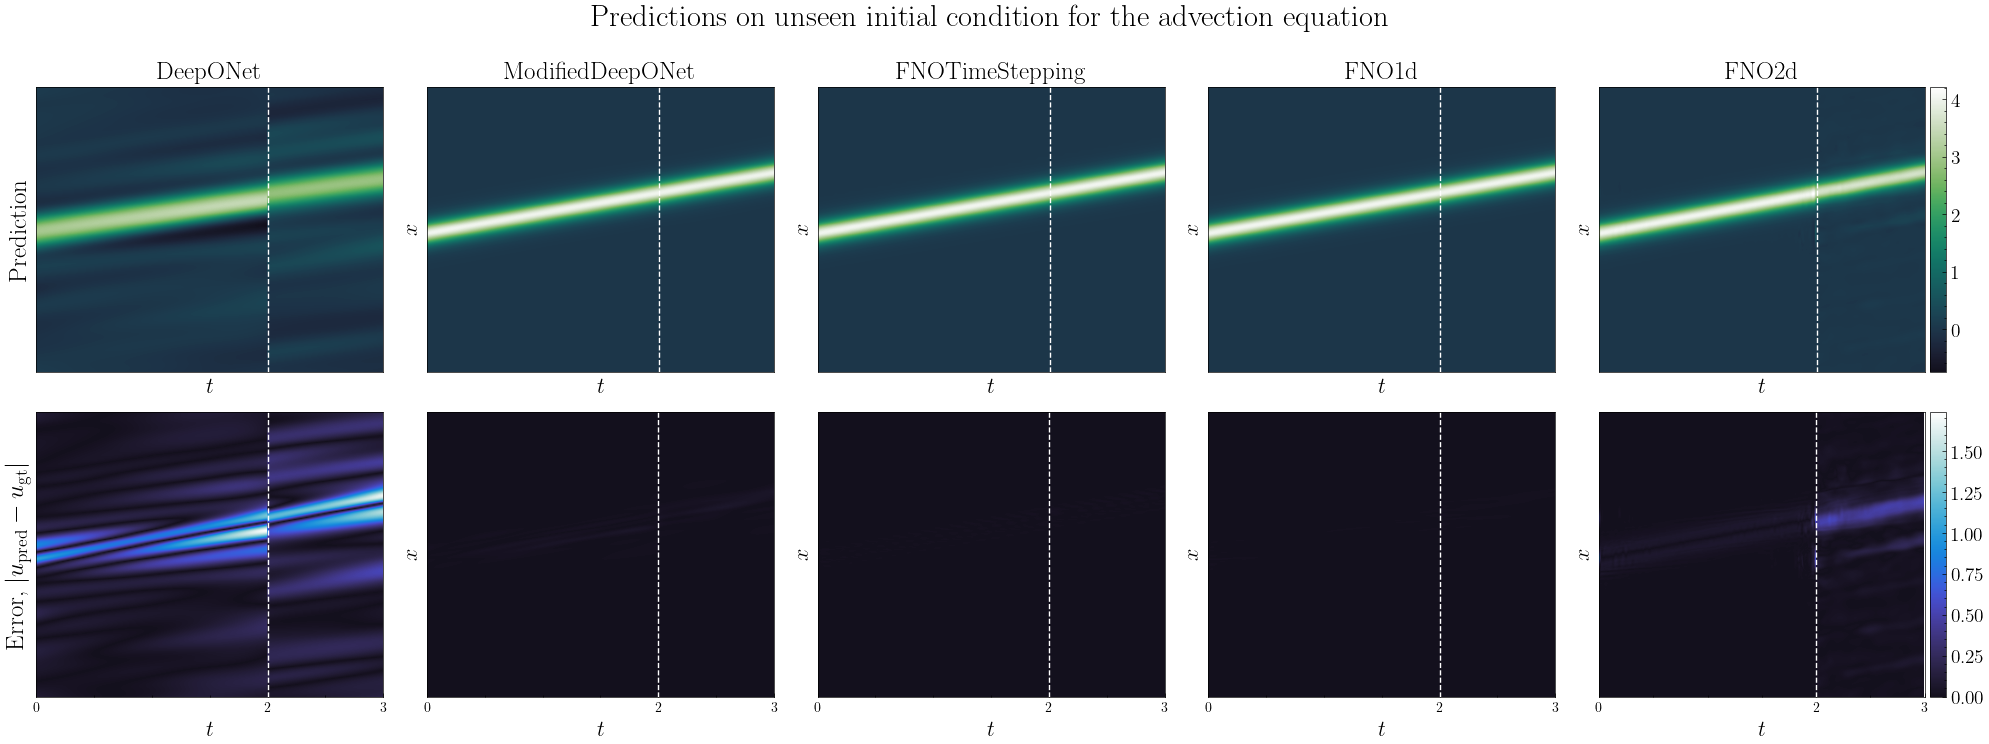

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(2, len(u_preds), figsize=(20, 7.5))

vmin_pred, vmax_pred = min(u_pred.min() for u_pred in u_preds.values()), max(u_pred.max() for u_pred in u_preds.values())
vmin_error, vmax_error = 0, max(jnp.abs(u_pred - u_gt).max() for u_pred in u_preds.values())

for i, (model_name, u_pred) in enumerate(u_preds.items()):
    # First row: imshow of u_pred
    ax1 = axes[0, i]
    im1 = ax1.imshow(u_pred.T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower', vmin=vmin_pred, vmax=vmax_pred)
    ax1.set_title(pretty_names[model_name], fontsize=18)
    ax1.set_xlabel(r'$t$', fontsize=16)
    ax1.set_ylabel(r'$x$', fontsize=16)
    ax1.axvline(x=2, color='white', linestyle='--')  # Add dashed line for t_test == 2
    ax1.tick_params(
                top=False,
                right=False, 
                bottom=False, 
                left=False,
                labelleft=False, 
                labelbottom=False, 
                which='both')
    
    # Second row: imshow of u_pred - u_gt
    ax2 = axes[1, i]
    im2 = ax2.imshow(jnp.abs(u_pred - u_gt).T, aspect='auto', cmap=cmap_error, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower', vmin=vmin_error, vmax=vmax_error)
    ax2.set_xlabel(r'$t$', fontsize=16)
    ax2.set_ylabel(r'$x$', fontsize=16)
    ax2.axvline(x=2, color='white', linestyle='--')
    ax2.set_xticks([0, 2, 3]) 
    ax2.tick_params(
            top=False,
            right=False, 
            #bottom=False, 
            left=False,
            labelleft=False, 
            #labelbottom=False, 
            which='both')

# Create a single colorbar for the first row
divider1 = make_axes_locatable(axes[0, -1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.ax.tick_params(labelsize=14)

# Create a single colorbar for the second row
divider2 = make_axes_locatable(axes[1, -1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = fig.colorbar(im2, cax=cax2)
cbar2.ax.tick_params(labelsize=14)

axes[0, 0].set_ylabel('Prediction', fontsize=18)
axes[1, 0].set_ylabel(r'Error, $|u_{\text{pred}} - u_{\text{gt}}|$', fontsize=18)

fig.suptitle('Predictions on unseen initial condition for the advection equation', fontsize=22, x=0.5, y=1)

plt.tight_layout()
plt.savefig("predictions/pred_advection_imshow.svg")
plt.show()

# Loss plot

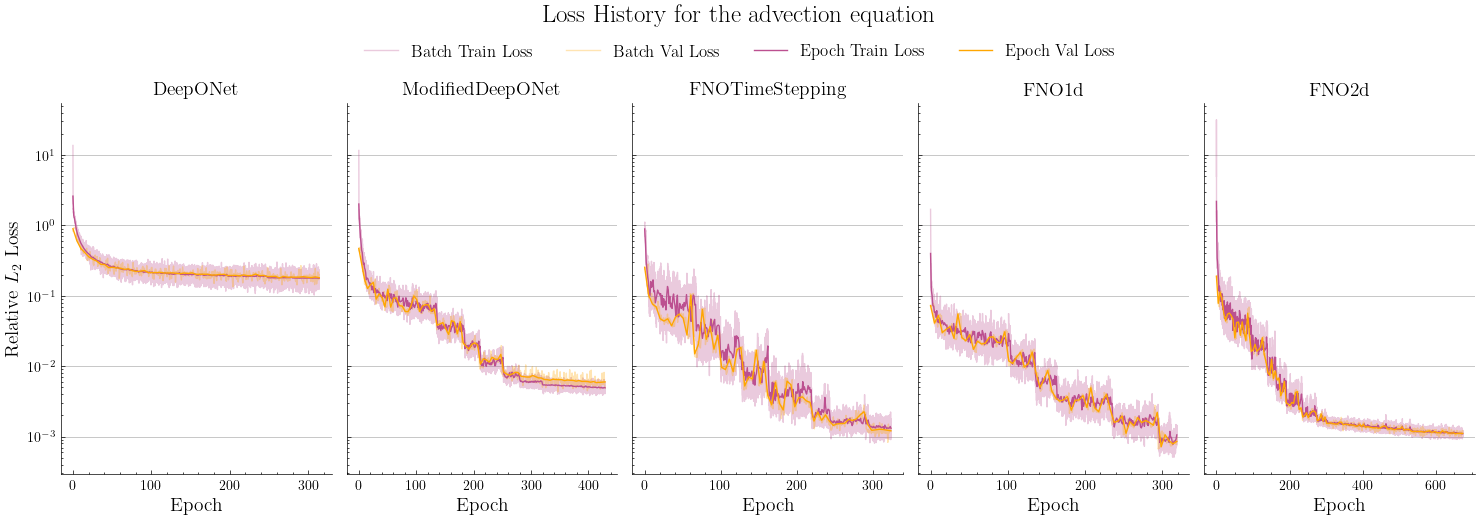

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
methods = list(trainers.keys())
train_color = '#bc5090'
val_color = '#ffa600'

for i, (model_name, trainer) in enumerate(trainers.items()):
        ax = axes[i]
        
        # Plot batch loss
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.train_loss_history_batch)),
                trainer.train_loss_history_batch, color=train_color, alpha=0.3, label='Batch Train Loss')
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.val_loss_history_batch)),
                trainer.val_loss_history_batch, color=val_color, alpha=0.3, label='Batch Val Loss')
        
        # Plot epoch loss
        ax.plot(jnp.arange(len(trainer.train_loss_history)), trainer.train_loss_history, 
                color=train_color, label='Epoch Train Loss')
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.val_loss_history)), 
                trainer.val_loss_history, 
                color=val_color, label='Epoch Val Loss')
        
        ax.set_title(pretty_names[model_name], fontsize=14)
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_yscale('log')
        ax.tick_params(
                top=False,
                right=False, 
                which='both')
        ax.grid(True, which='major', axis='y', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
axes[0].set_ylabel(r'Relative $L_2$ Loss', fontsize=14)   

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.), fontsize='large')

fig.suptitle('Loss History for the advection equation', fontsize=18, x=0.5, y=1.05)
plt.tight_layout()
plt.savefig("loss/loss_advection.svg")
plt.show()